In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

## Import data

In [2]:
#import Aitchison distance matrix 
dm = pd.read_csv('../data/SMDS_aitchison_distance_matrix.tsv', sep='\t', index_col=0)

## Reformat distance matrix

In [3]:
#melt distance matrix and convert to pandas dataframe 
meltaitch = dm.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['col1','col2','distance']

#remove self-self samples (zero distance)
df = df[df['col1']!=df['col2']]
#remove duplicates (since it is a symmetrical distance matrix)
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
df = df.drop_duplicates('check_string')

In [4]:
#split sample names to break down comparisons, and merge into one dataframe
df1 = df.col1.str.split('.',expand=True)
df1.columns=['samp','tx']

df2 = df.col2.str.split('.',expand=True)
df2.columns=['samp2','tx2']

dff = pd.concat([df1, df2, df], axis=1)

#add in HostSubject ID
dff['HostSubject1'] = dff['samp'].str[0:1]
dff['HostSubject2'] = dff['samp2'].str[0:1]
dff.head()

,samp,tx,samp2,tx2,col1,col2,distance,check_string,HostSubject1,HostSubject2
1,A1,lyPMA,A4,lyPMA,A1.lyPMA,A4.lyPMA,34.013113,A1.lyPMAA4.lyPMA,A,A
2,A1,lyPMA,A1,raw,A1.lyPMA,A1.raw,14.836186,A1.lyPMAA1.raw,A,A
3,A1,lyPMA,A2,lyPMA,A1.lyPMA,A2.lyPMA,29.424909,A1.lyPMAA2.lyPMA,A,A
4,A1,lyPMA,A2,raw,A1.lyPMA,A2.raw,29.983539,A1.lyPMAA2.raw,A,A
5,A1,lyPMA,A3,lyPMA,A1.lyPMA,A3.lyPMA,22.638635,A1.lyPMAA3.lyPMA,A,A


### raw and PMA-treated samples from the same saliva sample were more similar than samples from the same person processed the same way over time

In [5]:
# create function to label different distance types
# id distances that are between the same saliva sample processed different ways (i.e. PMA vs raw)
# and distances that are between the same person over time processed the same way
def f(row):
    if (row['samp']==row['samp2']):
           val = "same_sample_diff_processing"
    elif ((row['HostSubject1']==row['HostSubject2'])&
         (row['tx']==row['tx2'])):
            val = 'same_preson_over_time_same_processing'
    else:
        val = "something_else"
    return val

dff['PMA_distance_cat'] = dff.apply(f, axis=1)

In [6]:
stats.kruskal((dff[dff['PMA_distance_cat']=='same_sample_diff_processing']['distance']),
              (dff[dff['PMA_distance_cat']=='same_preson_over_time_same_processing']['distance']))
              

KruskalResult(statistic=58.393831576971024, pvalue=2.1456268407204648e-14)

## Plot Figure 3D

In [7]:
# create function to label different distance types
# id distances that are between samples from the same person processed the same way
def f(row):
    if (row['HostSubject1']==row['HostSubject2'])&(row['samp']!=row['samp2'])&(row['tx']==row['tx2']):
        val = "same_person_same_method_over_time"
    else:
        val = "something_else"
    return val

dff['distance_cat'] = dff.apply(f, axis=1)

In [8]:
# print number of samples that got categorized as within person
dff['distance_cat'].value_counts()

something_else                       14712
same_person_same_method_over_time      688
Name: distance_cat, dtype: int64

In [9]:
# subset out distances between timepoints from same person
spsm = dff[dff['distance_cat']=='same_person_same_method_over_time']
spsm.shape

(688, 12)

In [10]:
# reorder spsm so raw samples are shown first when plotting
spsm = spsm.sort_values(by=['tx'], ascending=False)

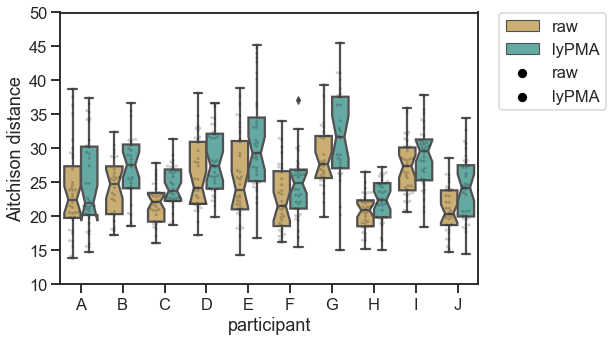

In [12]:
order=['A','B','C','D','E','F','G','H','I','J']
sns.set_style('ticks')
sns.set_context('talk')
f, ax = plt.subplots()
f.set_size_inches(7.5,5)

ax = sns.boxplot(x='HostSubject1', y='distance', hue='tx', data=spsm, palette=['#d8b365','#5ab4ac'], notch=True, order=order)
ax = sns.swarmplot(x='HostSubject1', y='distance', hue='tx', data=spsm, size=3, palette=['#000000','#000000'],dodge=True, alpha=0.2, order=order)
ax.set(ylabel='Aitchison distance')
ax.set(xlabel='participant')
ax.set(ylim=(10,50))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#f.savefig('/Users/lisamarotz/Dropbox/Lisa_stuff/Thesis/publications/Saliva_quant/Figures/Figure3_dynamics/Figure3D_aitchison_distance_processing.pdf',
#            bbox_inches='tight')

## Run Kruskal-Wallis test between raw and PMA sample distances per participant

In [15]:
parts = ['A','B','C','D','E','F','G','H','I','J']
for i in parts:
    print(i, stats.kruskal((spsm[(spsm['HostSubject1']==i)&(spsm['tx']=='raw')]['distance']),
                             (spsm[(spsm['HostSubject1']==i)&(spsm['tx']=='lyPMA')]['distance'])))

A KruskalResult(statistic=0.3299086757990608, pvalue=0.5657128680189176)
B KruskalResult(statistic=4.4685821697099755, pvalue=0.03452362820326721)
C KruskalResult(statistic=9.453196347031962, pvalue=0.002107814604975002)
D KruskalResult(statistic=4.627219685438831, pvalue=0.031468518906791865)
E KruskalResult(statistic=9.246575342465746, pvalue=0.002359362402710825)
F KruskalResult(statistic=2.9304921359715763, pvalue=0.0869209923753656)
G KruskalResult(statistic=4.128893662728245, pvalue=0.04215690282781882)
H KruskalResult(statistic=5.917808219178056, pvalue=0.014988592847887113)
I KruskalResult(statistic=2.41552511415523, pvalue=0.1201376784394071)
J KruskalResult(statistic=7.366945712836099, pvalue=0.006643367632449267)


In [17]:
# Same data, run permutation test
from perm_test import perm_kruskal_test
parts = ['A','B','C','D','E','F','G','H','I','J']
for i in parts:
    print(i, perm_kruskal_test((spsm[(spsm['HostSubject1']==i)&(spsm['tx']=='raw')]['distance']),
                               (spsm[(spsm['HostSubject1']==i)&(spsm['tx']=='lyPMA')]['distance'])))

A (0.3299086757990608, 0.5584415584415584)
B (4.4685821697099755, 0.03796203796203796)
C (9.453196347031962, 0.002997002997002997)
D (4.627219685438831, 0.03696303696303696)
E (9.246575342465746, 0.003996003996003996)
F (2.9304921359715763, 0.08791208791208792)
G (4.128893662728245, 0.03896103896103896)
H (5.917808219178056, 0.017982017982017984)
I (2.41552511415523, 0.11688311688311688)
J (7.366945712836099, 0.005994005994005994)
